https://www.youtube.com/watch?v=TLPmlVeEf1k

In [1]:
!pip3 install bertopic[all]

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 6.4 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.2 MB 93 kB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 1.3 MB 41.3 MB/s 
     |████████████████████████████████| 5.8 MB 41.7 MB/s 
     |████████████████████████████████| 776.7 MB 4.7 kB/s 
     |████████████████████████████████| 4.4 MB 43.6 MB/s 
     |████████████████████████████████| 448 kB 36.0 MB/s 
     |████████████████████████████████| 981 kB 48.7 MB/s 
     |████████████████████████████████| 788 kB 43.5 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
     |█████████████████████████

## Pass 1: Topic Modeling with BERTopic

Mostly borrowed from [BERTopic's original repository](https://github.com/MaartenGr/BERTopic/). Included for video demo

In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

In [2]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [3]:
print(f"Number of documents = {len(docs)}")

Number of documents = 18846


In [4]:
docs[1]

'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-performance VLB card\n\n\nPlease post or email.  Thank you!\n\n  - Matt\n'

In [5]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(docs)

  0%|          | 0.00/83.4M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

6881 documents have not been classified
The other 11965 documents are 184 topics


In [7]:
topic_freq.head()

,Topic,Count
0,-1,6881
1,0,1797
2,1,675
3,2,630
4,3,520


In [8]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 1797 documents that are talking about topic ID 0


In [9]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

[('game', 0.010669249559000712),
 ('team', 0.009406660232483884),
 ('players', 0.006555681544542671),
 ('hockey', 0.006336067504188585),
 ('league', 0.00515960990508164),
 ('teams', 0.004817537642983009),
 ('player', 0.004607629192842835),
 ('nhl', 0.004262071903339141),
 ('goal', 0.003603083268382353),
 ('hit', 0.0035904382523735314)]

Let's visualize these topics in the embedding space!

In [10]:
topic_model.visualize_topics()

We can do some topic reduction. But won't talk about that here. Refere the original repo for more information.

## Pass 2: Breaking down BERTopic

The code in this section is brought to you by [this blog post](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6). Read for more info. Included here for explanatory purposes

In [ ]:
!pip install sentence_transformers
!pip install umap-learn
!pip install hdbscan

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import umap
import hdbscan
import numpy as np
import pandas as pd

In [ ]:
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens') # We'll get to this :)
embeddings = model.encode(docs)

In [ ]:
embeddings.shape

(18846, 768)

Every document is encoded into a 768 dim vector. But this is still high dimensional (especially if we are dealing with >100K documents).

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
umap_embeddings.shape

(18846, 5)

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10, 
                          metric='euclidean', 
                          cluster_selection_method='eom'
                          ).fit(umap_embeddings)

In [ ]:
print(f"Number of clusters = {np.unique(cluster.labels_).shape[0] - 1}")

Number of clusters = 105


$$
CTFIDF_i = \frac{t_i}{w_i} \times log \frac{D}{\sum_n t_n}
$$

$t_i = \text{Number of occurances of current word in documents of the } i^{th} \text{topic/cluster}$

$w_i = \text{Number of distinct words in all clustered documents}$

$D = \text{Number of clusters}$

$\sum_n t_n = \text{Sum of occurances current word in all clustered document}$

In [ ]:
docs_df = pd.DataFrame(docs, columns=['document'])
docs_df['topic'] = cluster.labels_
docs_per_topic = docs_df.groupby(['topic']).agg({'document': ' '.join})

In [ ]:
docs_per_topic = docs_per_topic.reset_index()

In [ ]:
def CTfIDF(documents):
    count = CountVectorizer(stop_words='english').fit(documents)
    t = count.transform(documents).toarray() #num_clusters x num_words
    w = t.sum(axis=1) # num_clusters x 1
    tf = np.divide(t.T, w) #num_words x num_clusters
    D = len(documents) # num_clusters x 1
    sum_t = t.sum(axis=0) #num_words x 1
    idf = np.log(np.divide(D, sum_t)).reshape(-1, 1) # num_words x 1
    tf_idf = np.multiply(tf, idf) #num_words x num_clusters
    return tf_idf, count

In [ ]:
tf_idf, count = CTfIDF(docs_per_topic['document'].values)

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .document
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "document": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)

In [ ]:
topic_sizes.head(10)

,topic,size
0,-1,9783
12,11,683
79,78,593
14,13,559
26,25,522
28,27,508
22,21,483
3,2,461
19,18,277
53,52,259


In [ ]:
top_n_words[11]

[('astronauts', 0.00045323178620000935),
 ('asteroid', 0.0004468113549640627),
 ('uranus', 0.0004455782644774572),
 ('asteroids', 0.00044194807257956487),
 ('interstellar', 0.0004416775511039884),
 ('centaur', 0.00043990143954706793),
 ('oort', 0.00043412402149059737),
 ('orbits', 0.0004329247049019912),
 ('rocketry', 0.00042835763726090516),
 ('ariane', 0.00042657109289412647)]

In [ ]:
top_n_words[78]

[('liturgy', 0.0004956175547443563),
 ('coptic', 0.00047589420712145793),
 ('elijah', 0.0004453153712250014),
 ('tomb', 0.00043429072366715023),
 ('commandment', 0.0003900095423169545),
 ('baptize', 0.0003875620372639343),
 ('apacgw', 0.0003862159917386125),
 ('taize', 0.0003862159917386125),
 ('darren', 0.0003832334971522111),
 ('baptized', 0.0003765311356610358)]

## Pass 3: Breakdown: UMAP, HDBSAN, SentenceTransformers

### 3.1 Sentence Transformer

How do we get sentence embeddings? Here is the simplest sentence transformer

<img src="https://www.sbert.net/_images/SBERT_Architecture.png">

But this leads to bad embeddings (even words than glove embeddings). Evidence on in the 3rd paragraph of the introduction of the [paper that lays out Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf).

Instead, train on one (or both) of:
- Natural Language Inference [(NLI)](https://www.sbert.net/docs/pretrained-models/nli-models.html)
- Sentence Test Similarity [(STS)](https://www.sbert.net/docs/pretrained-models/sts-models.html)

<img src="https://roomylee.github.io/assets/images/blog/2020-02-20-sentence-bert/figure1-and-2.png">

Triplet could be this:
- `anchor`: Say hello to me.  
- `contradiction`: Don't say anything to me 
- `entailment`: Say something to me

Depending on the objective and the base model of BERT we have, we can create different SentenceTransformers. The one we use is `distilbert-base-nli-stsb-mean-tokens`, which I think is basically:
- Uses a BERT base
- Trains on NLI 
- Further fine tuning on STS 
- Uses MEAN pooling for creating the initial sentence embedding. 


For proof,check [STS Models](https://www.sbert.net/docs/pretrained-models/sts-models.html)

### 3.2 UMAP

non-linear dimensionality reduction technique. [Here](https://www.youtube.com/watch?v=nq6iPZVUxZU&ab_channel=Enthought) is a video by the creator for a good explanation. Warning! Math heavy!

### 3.2 HDBSCAN

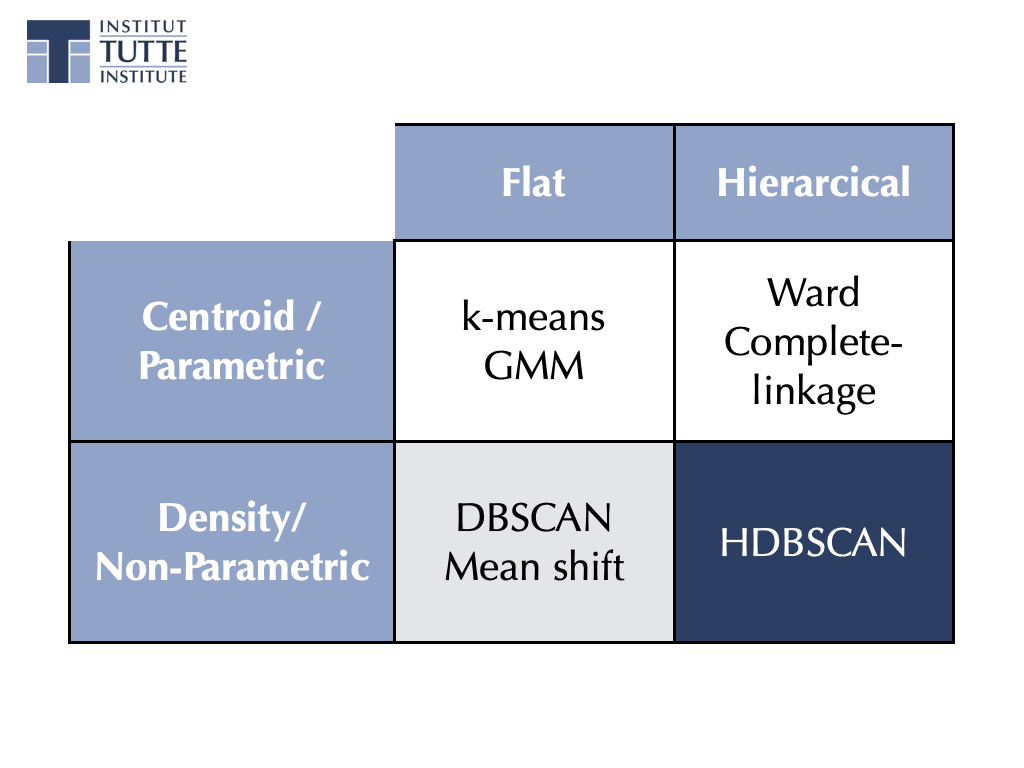

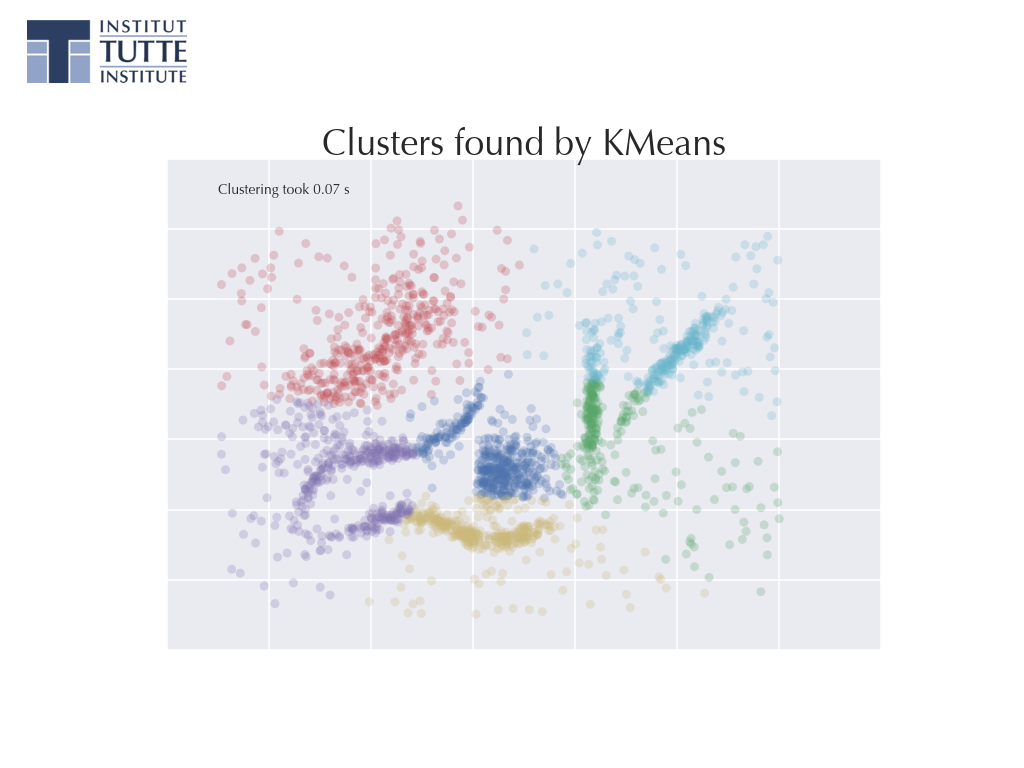

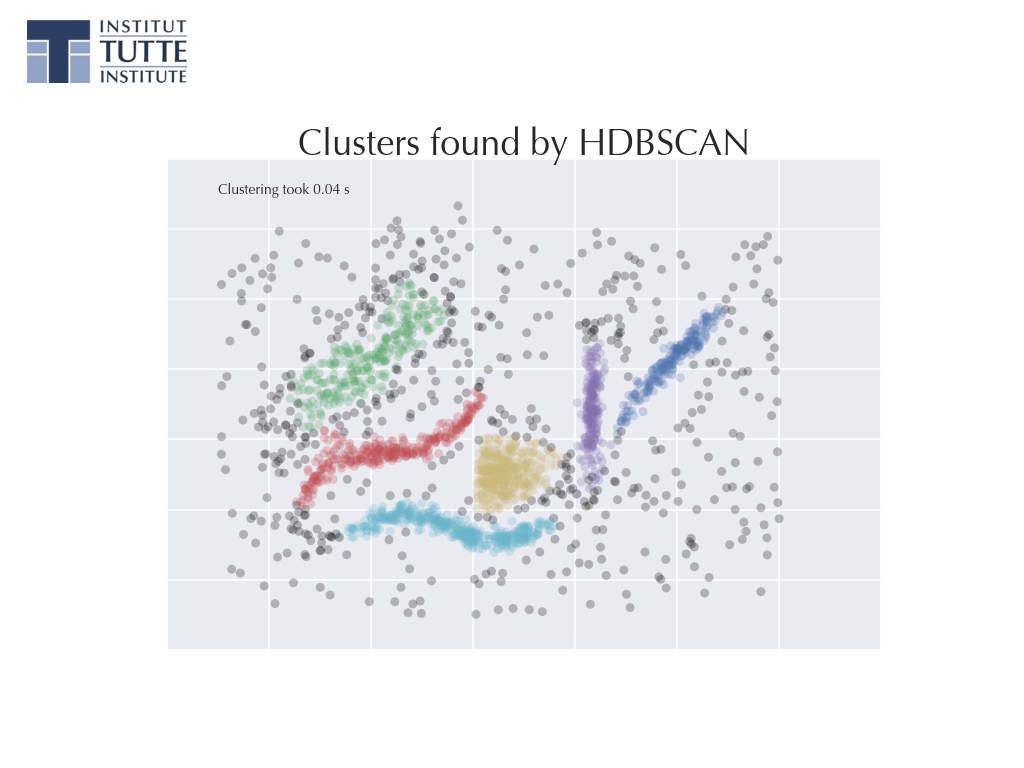